# Evaluate on Robert's dataset

In [2]:
from PIL import Image
import os

GRAPHCLIP_DIR = os.path.abspath(os.path.abspath("") + "/..")
ROBERT_DATASET_PATH = GRAPHCLIP_DIR +'/datasets/visual_genome/raw/realistic_adversarial_attributes_gt_accepted_pruned.json'
JONATHAN_DATASET_V1_PATH = GRAPHCLIP_DIR +  '/datasets/visual_genome/processed/ra_selections_curated_adversarial.pt'
JONATHAN_DATASET_V2_PATH = GRAPHCLIP_DIR + '/datasets/visual_genome/processed/ra_selections_curated_adversarial2.pt'
IMAGE_DIR = GRAPHCLIP_DIR + '/datasets/visual_genome/raw/'
# EVALUATOR_NAME = 'ViT-L/14'
EVALUATOR_NAME = 'GraphCLIP'

def get_image(image_id: int):
    try:
        image = Image.open(IMAGE_DIR + "VG/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K_2/" + str(image_id) + '.jpg')
        return image
    except:
        raise Exception(f"Could not find image with id {image_id}")

In [3]:
import relational_image_generation_evaluation as rige

/home/robert/.pyenv/versions/3.9.7/envs/jonathan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/robert/.pyenv/versions/3.9.7/envs/jonathan/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
import json
with open(ROBERT_DATASET_PATH, 'r') as f:
    data = json.load(f)
    print(len(data))

100


In [5]:
import networkx as nx
graphs = []
for sample in data:
    graph = nx.DiGraph()
    graph.image_id = sample['image_id']
    obj1_name = sample['objects'][0]['names'][0]
    obj1_id = sample['objects'][0]['object_id']
    obj2_name = sample['objects'][1]['names'][0]
    obj2_id = sample['objects'][1]['object_id']
    obj1_attrs = sample['objects'][0]['attributes']
    obj2_attrs = sample['objects'][1]['attributes']
    assert obj1_name in rige.FILTERED_OBJECTS, f"obj1_attrs: {obj1_attrs}"
    assert obj2_name in rige.FILTERED_OBJECTS, f"obj2_attrs: {obj2_attrs}"
    for attr in obj1_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj1_attrs: {obj1_attrs}"
    for attr in obj2_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj2_attrs: {obj2_attrs}"
    # add nodes with attributes and labels
    graph.labels = {}
    graph.add_node(obj1_id, attributes=obj1_attrs, name=obj1_name)
    graph.labels[obj1_id] = obj1_name
    graph.add_node(obj2_id, attributes=obj2_attrs, name=obj2_name)
    if EVALUATOR_NAME == "GraphCLIP":
        graph.add_edge(obj1_id, obj2_id, predicate="and")
        graph.add_edge(obj2_id, obj1_id, predicate="and")
    graph.labels[obj2_id] = obj2_name
    graphs.append(graph)
    

In [6]:
evaluator = rige.Evaluator(EVALUATOR_NAME)

Not enough memory on GPU, using CPU
Using device cpu for evaluation.


In [7]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for graph in graphs[:]:
    image_id = graph.image_id
    image_orig = get_image(image_id)
    image_adv = get_image(image_id)
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
try:
    print(scores_orig['attr_scores'])
    print(scores_adv['attr_scores'])
except:
    print(scores_orig['overall_scores'])
    print(scores_adv['overall_scores'])

100%|██████████| 100/100 [05:37<00:00,  3.37s/it]

[2.099586009979248, 3.1290910243988037, 3.7015068531036377, 4.002997875213623, 4.018897533416748, 2.132471799850464, 2.3655405044555664, 3.5084681510925293, 6.9538798332214355, 4.326342582702637, 5.1049275398254395, 4.762594699859619, 3.651582956314087, 3.2632360458374023, 4.081754684448242, 4.88073205947876, 4.716102600097656, 5.379328727722168, 2.3812437057495117, 2.542081356048584, 4.447091102600098, 3.342438220977783, 5.893896579742432, 4.467082977294922, 4.705615520477295, 3.9161410331726074, 4.490429878234863, 3.4368059635162354, 4.611466407775879, 4.551474094390869, 3.8243775367736816, 3.639558792114258, 5.075483798980713, 5.099102020263672, 4.8534979820251465, 5.262186527252197, 4.928718566894531, 5.896496772766113, 3.2342233657836914, 3.8361973762512207, 3.4522128105163574, 4.395862102508545, 6.91162109375, 4.034177303314209, 3.4216256141662598, 4.263723850250244, 3.0080113410949707, 2.695077896118164, 2.911717176437378, 3.1919987201690674, 2.702343463897705, 2.853579998016357

In [8]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
wrong_indices = []
try:
    orig_adv_pairs = zip(scores_orig['attr_scores'],scores_adv['attr_scores'])
except:
    orig_adv_pairs = zip(scores_orig['overall_scores'],scores_adv['overall_scores'])
for i,(orig,adv) in enumerate(orig_adv_pairs):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1
        wrong_indices.append(i)

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

n_correct: 88, n_incorrect: 12, accuracy: 0.88


## Show the wrongly predicted ones
(running generates lot of output)

107910
woman  with attributes:  ['blonde']
boy  with attributes:  ['standing']
3.7015068531036377
3.8008475303649902


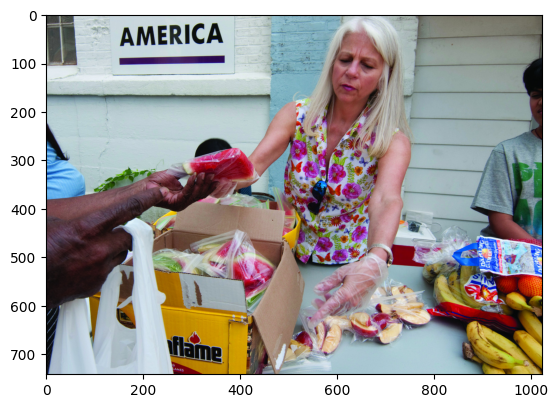

107910
box  with attributes:  ['yellow']
wall  with attributes:  ['white']
2.3655405044555664
3.379871129989624


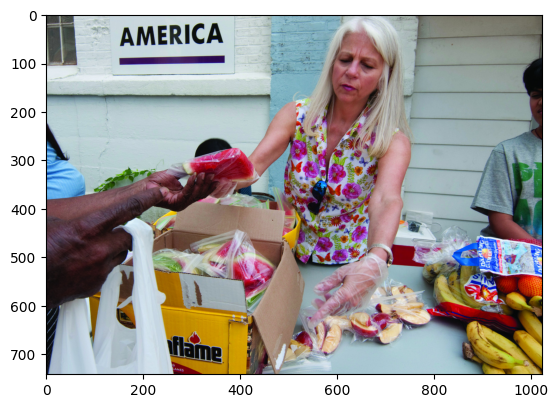

150502
floor  with attributes:  ['grey']
chair  with attributes:  ['orange']
3.2632360458374023
3.660466194152832


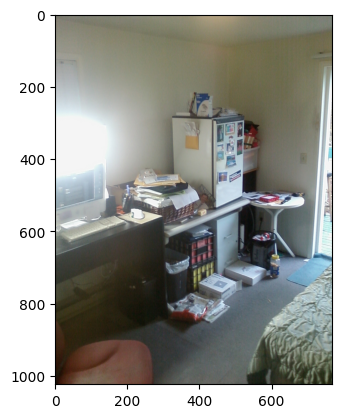

2410457
umbrella  with attributes:  ['yellow']
boat  with attributes:  ['white']
3.8361973762512207
3.8394296169281006


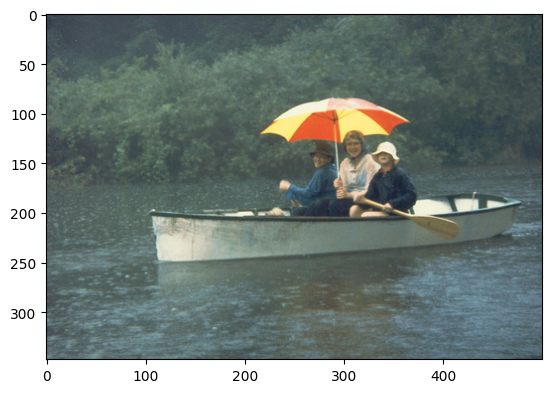

2
sidewalk  with attributes:  ['white']
pole  with attributes:  ['brown']
3.3785805702209473
3.4560816287994385


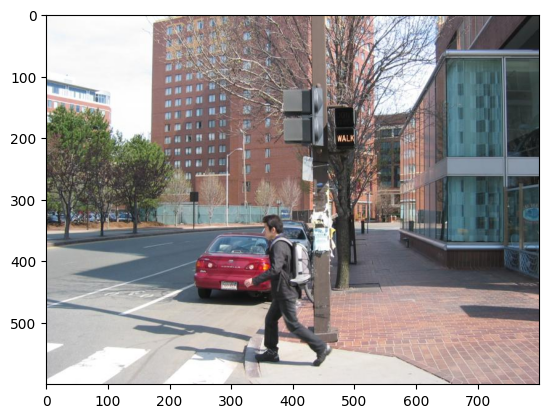

18
table  with attributes:  ['white']
shelf  with attributes:  ['brown']
3.0255885124206543
3.1133182048797607


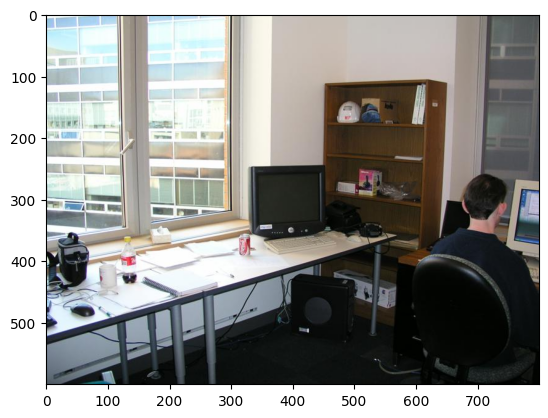

102
road  with attributes:  ['blue']
building  with attributes:  ['brick']
2.5945374965667725
3.1371757984161377


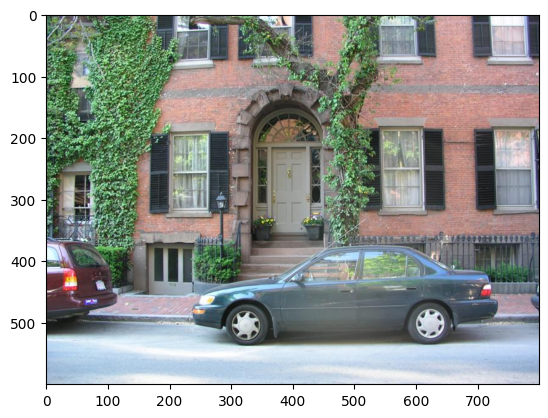

191
water  with attributes:  ['clear']
sky  with attributes:  ['grey']
2.30617094039917
2.884964942932129


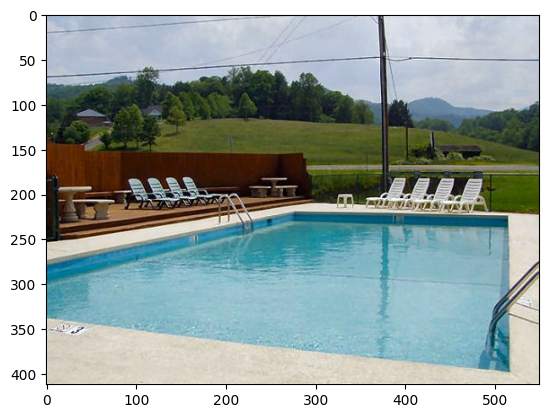

213
roof  with attributes:  ['green']
tree  with attributes:  ['colorful']
2.796133041381836
3.2928390502929688


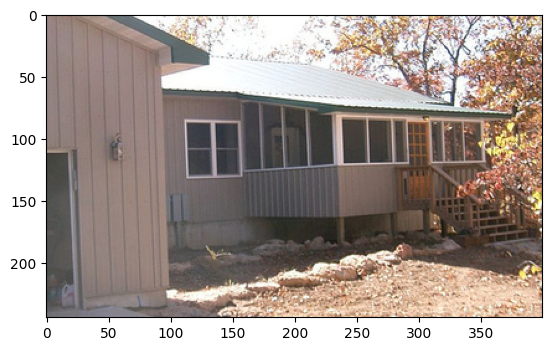

271
fence  with attributes:  ['beige']
road  with attributes:  ['black']
3.0820209980010986
3.678168773651123


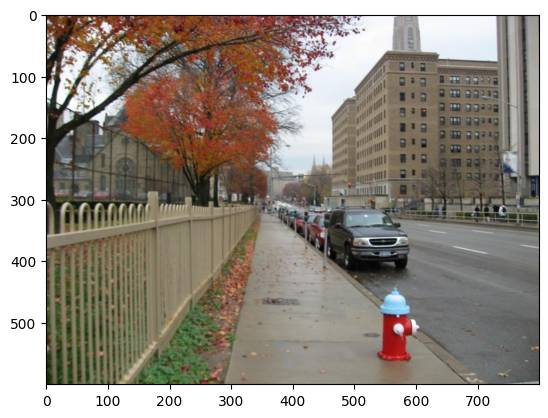

2402196
box  with attributes:  ['white']
wall  with attributes:  ['brown']
3.178901195526123
4.081052303314209


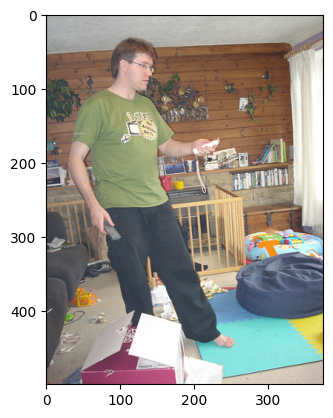

2378891
table  with attributes:  ['red']
floor  with attributes:  ['white']
3.269742250442505
3.4986958503723145


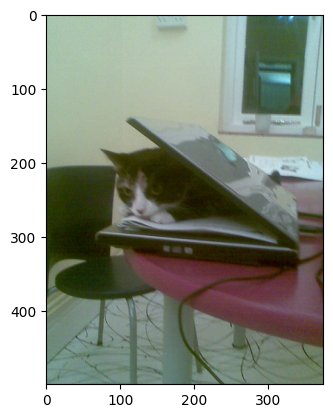

In [9]:
import matplotlib.pyplot as plt
for i,graph in enumerate(graphs):
    if i in wrong_indices:
        print(graph.image_id)
        obj1_name = graph.nodes[list(graph.nodes)[0]]['name']
        obj2_name = graph.nodes[list(graph.nodes)[1]]['name']
        print(obj1_name, " with attributes: ", graph.nodes[list(graph.nodes)[0]]['attributes'])
        print(obj2_name, " with attributes: ", graph.nodes[list(graph.nodes)[1]]['attributes'])
        try:
            print(scores_orig['attr_scores'][i])
            print(scores_adv['attr_scores'][i])
        except:
            print(scores_orig['overall_scores'][i])
            print(scores_adv['overall_scores'][i])
        # plot the image
        image = get_image(graph.image_id)
        plt.imshow(image)
        plt.show()

# Evaluate on Jonathan's Dataset
run Robert's first, the imports are not done again

In [10]:
import torch
# copied from somewhere else
def get_realistic_graphs_dataset_rel(version):
    if version == 'v1':
        curated_adversarialt = torch.load(JONATHAN_DATASET_V1_PATH) # a dict with image_id as key and a graph and the adversarial perturbations as value
    elif version == 'v2':
        curated_adversarialt = torch.load(JONATHAN_DATASET_V2_PATH)
    else:
        raise ValueError(f"version {version} not recognized")
    # the format of the dict is {image_id: [(original_graph,graph_edge,adv_predicate), ...]}
    # we return a list of tuples (graphs, adv_graph, adv_edge, adv_predicate) for each image for each adversarial perturbation
    dataset = []
    for original_graph, graph_edge, adv_predicate in curated_adversarialt:
        adv_graph = rige.copy_graph(original_graph)
        adv_graph.edges[graph_edge]['predicate'] = adv_predicate
        dataset.append({
            'original_graph': original_graph,
            'adv_graph': adv_graph,
            'changed_edge': graph_edge,
            'adv_predicate': adv_predicate
        })
    return dataset

dataset_v1 = get_realistic_graphs_dataset_rel('v1')
dataset_v2 = get_realistic_graphs_dataset_rel('v2')

In [36]:
import networkx as nx
def extract_one_edge_graph(graph, edge):
    g = nx.Graph()
    g.image_id = graph.image_id
    if not EVALUATOR_NAME == "GraphCLIP":
        g.add_node(edge[0], name=graph.nodes[edge[0]]['name'], attributes=graph.nodes[edge[0]]['attributes'])
        g.add_node(edge[1], name=graph.nodes[edge[1]]['name'], attributes=graph.nodes[edge[1]]['attributes'])
    g.add_node(edge[0], name=graph.nodes[edge[0]]['name'], attributes=[])
    g.add_node(edge[1], name=graph.nodes[edge[1]]['name'], attributes=[])
    g.add_edge(edge[0], edge[1], predicate=graph.edges[edge]['predicate'])
    return g

In [37]:
from tqdm import tqdm
def evaluate_dataset(dataset):
    images_orig = []
    graphs_orig = []
    images_adv = []
    graphs_adv = []
    for d in dataset[:]:
        orig_graph = d['original_graph']
        adv_graph = d['adv_graph']
        edge = d['changed_edge']
        orig_graph = extract_one_edge_graph(orig_graph, edge)
        adv_graph = extract_one_edge_graph(adv_graph, edge)
        image_id = orig_graph.image_id
        image_orig = get_image(image_id)
        image_adv = get_image(image_id)
        images_orig.append(image_orig)
        graphs_orig.append(orig_graph)
        images_adv.append(image_adv)
        graphs_adv.append(adv_graph)
    scores_orig = evaluator(images_orig,graphs_orig)
    scores_adv = evaluator(images_adv,graphs_adv)
    return scores_orig, scores_adv

print("evaluating dataset v1")
scores_orig_v1, scores_adv_v1 = evaluate_dataset(dataset_v1)
print("evaluating dataset v2")
scores_orig_v2, scores_adv_v2 = evaluate_dataset(dataset_v2)


evaluating dataset v1


100%|██████████| 103/103 [04:46<00:00,  2.79s/it]


evaluating dataset v2


100%|██████████| 63/63 [03:02<00:00,  2.90s/it]


In [38]:
try:
    print(scores_orig_v2['rel_scores'])
    print(scores_adv_v2['rel_scores'])
    print(scores_orig_v2['attr_scores'])
    print(scores_adv_v2['attr_scores'])
except:
    print(scores_orig_v2['overall_scores'])
    print(scores_adv_v2['overall_scores'])

[5.994837760925293, 3.069960832595825, 5.948488712310791, 6.176013469696045, 2.257373809814453, 2.379912853240967, 5.217866897583008, 4.330857276916504, 3.7344889640808105, 4.560420989990234, 2.882171154022217, 5.622250556945801, 4.212906360626221, 5.396461486816406, 3.7698185443878174, 3.2251954078674316, 3.586916923522949, 2.8962056636810303, 4.561182975769043, 3.252997636795044, 3.9142253398895264, 5.931271553039551, 4.657881736755371, 4.702625751495361, 5.048018932342529, 3.4572958946228027, 3.979922294616699, 3.336411476135254, 3.761871337890625, 3.1084415912628174, 4.842352867126465, 5.687788009643555, 3.423391580581665, 5.596391677856445, 4.152491569519043, 7.700181484222412, 3.3449931144714355, 3.8200623989105225, 2.249131202697754, 4.1929545402526855, 4.820812702178955, 5.429230213165283, 3.768683910369873, 4.2141499519348145, 3.3985579013824463, 5.079453945159912, 5.123791694641113, 3.5639538764953613, 4.324242115020752, 3.6323297023773193, 3.068067789077759, 5.77844953536987

In [39]:
def get_acc(scores_orig, scores_adv):
    n_good = 0
    n_bad = 0
    wrong_indices = []
    try:
        orig_adv_pairs = zip(scores_orig['rel_scores'],scores_adv['rel_scores'])
    except:
        orig_adv_pairs = zip(scores_orig['overall_scores'],scores_adv['overall_scores'])
    for i,(orig_rel,adv_rel) in enumerate(orig_adv_pairs):
        if orig_rel>adv_rel:
            n_good += 1
        else:
            n_bad += 1
            wrong_indices.append(i)
    return n_good, n_bad, wrong_indices
print("v1")
n_good, n_bad, wrong_indices_v1 = get_acc(scores_orig_v1, scores_adv_v1)
print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")
print("v2")
n_good, n_bad, wrong_indices_v2 = get_acc(scores_orig_v2, scores_adv_v2)
print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

v1
n_correct: 91, n_incorrect: 12, accuracy: 0.883495145631068
v2
n_correct: 51, n_incorrect: 12, accuracy: 0.8095238095238095


## Show the wrongly predicted ones
(running generates a long outut)

2392644
boy  with attributes:  []
bed  with attributes:  []
original predicate:  sitting in
adversarial predicate:  standing in
5.948488712310791
4.546864032745361


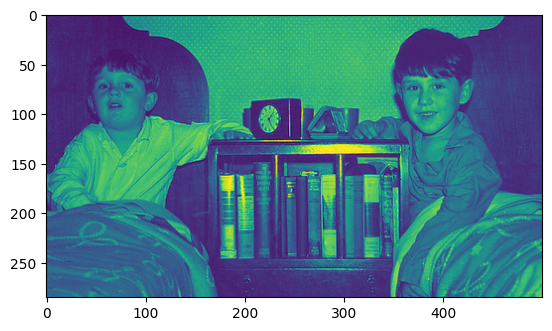

2317571
man  with attributes:  []
seat  with attributes:  []
original predicate:  sitting on
adversarial predicate:  lying on
5.217866897583008
2.7778513431549072


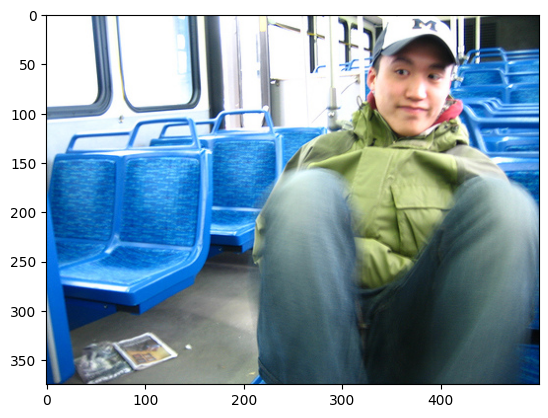

2355852
clock  with attributes:  []
building  with attributes:  []
original predicate:  on
adversarial predicate:  under
5.396461486816406
3.2016806602478027


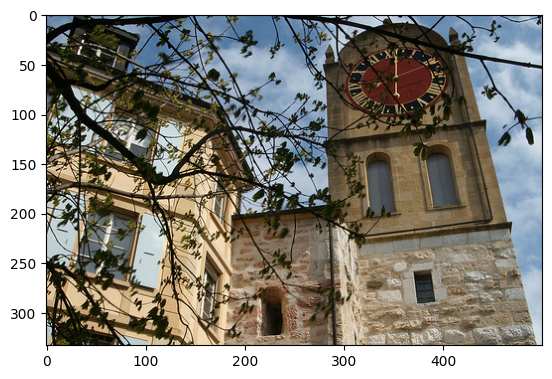

2410451
water  with attributes:  []
glass  with attributes:  []
original predicate:  in
adversarial predicate:  on
4.1929545402526855
1.4104948043823242


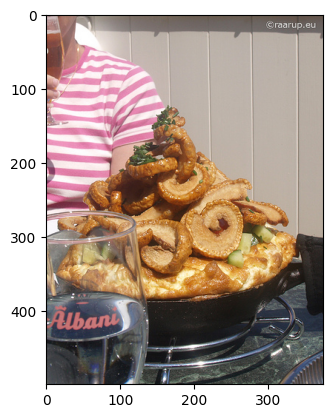

2403931
street  with attributes:  []
boy  with attributes:  []
original predicate:  behind
adversarial predicate:  in front of
6.251344203948975
5.378256797790527


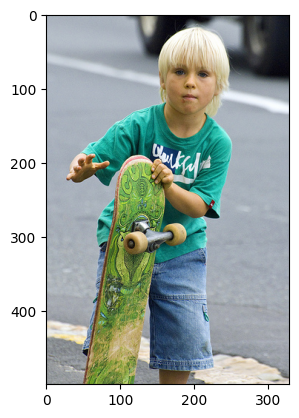

2379033
chair  with attributes:  []
ocean  with attributes:  []
original predicate:  in front of
adversarial predicate:  behind
4.216649055480957
3.598668098449707


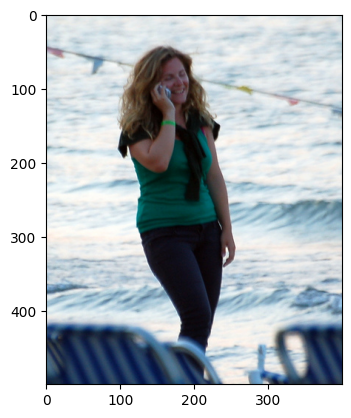

In [40]:
import matplotlib.pyplot as plt
for i,d in enumerate(dataset_v2):
    if i in wrong_indices:
        graph = extract_one_edge_graph(d['original_graph'], d['changed_edge'])
        graph_adv = extract_one_edge_graph(d['adv_graph'], d['changed_edge'])
        print(graph.image_id)
        obj1_name = graph.nodes[list(graph.nodes)[0]]['name']
        obj2_name = graph.nodes[list(graph.nodes)[1]]['name']
        print(obj1_name, " with attributes: ", graph.nodes[list(graph.nodes)[0]]['attributes'])
        print(obj2_name, " with attributes: ", graph.nodes[list(graph.nodes)[1]]['attributes'])
        edge_predicate = graph.edges[list(graph.edges)[0]]['predicate']
        print("original predicate: ", edge_predicate)
        edge_predicate = graph_adv.edges[list(graph_adv.edges)[0]]['predicate']
        print("adversarial predicate: ", edge_predicate)
        try:
            print(scores_orig_v2['rel_scores'][i])
            print(scores_adv_v2['rel_scores'][i])
        except:
            print(scores_orig_v2['overall_scores'][i])
            print(scores_adv_v2['overall_scores'][i])
        # plot the image
        image = get_image(graph.image_id)
        plt.imshow(image)
        plt.show()